In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from unidecode import unidecode
import regex as re

# Load data from sources

In [2]:
#Load songs and charts data 
songs = pd.read_csv("~/w266_project_topmusichits/data/raw/spotify_songs.csv",',')
charts = pd.read_csv("~/w266_project_topmusichits/data/raw/billboard_hot_100_charts.csv",',')

In [ ]:
# Preview songs data
songs.head(10)

In [ ]:
# Preview charts data
charts.head(10)

# Clean Songs and Charts Datasets

In [3]:
# CLEANING CHARTS DATASET NEW
# Extract year
charts['WeekID'] = pd.to_datetime(charts['WeekID'].str.strip(),format='%m/%d/%Y')
charts['Year'] = pd.DatetimeIndex(charts['WeekID']).year
print("Original number of rows:",len(charts))


# Filter out columns
new_charts = charts[['Year','Song','Performer','Weeks on Chart']]


# Aggregate song/performer to get earlier year and max weeks on chart
new_charts = new_charts.groupby(['Performer','Song']) \
                .agg({'Year':'min', 'Weeks on Chart':'max'}) \
                [['Year','Weeks on Chart']].reset_index()
print("Number of rows after aggregation:",len(new_charts))

# Sort songs by song, performer, and year
new_charts = new_charts.sort_values(['Song','Performer','Year'], 
                                     ascending=True)

# Filter out songs older than 1975 and newer than 2020
new_charts = new_charts[(new_charts['Year']>=1975) & (new_charts['Year']<=2022)]

print("Number of rows after filtering years:",len(new_charts))


# Rename Weeks on Chart and Year columns
new_charts.rename(columns={'Weeks on Chart': 'Weeks_On_Chart'}, inplace=True)
new_charts.rename(columns={'Year': 'trending_year'}, inplace=True)


Original number of rows: 327895
Number of rows after aggregation: 29389
Number of rows after filtering years: 18786


In [4]:
# Preview new charts dataframe
new_charts.head(20)

,Performer,Song,trending_year,Weeks_On_Chart
29112,Young And Restless,"""B"" Girls",1990,15
20103,Quincy Jones,"""Roots"" Medley",1977,7
18217,Nelly,#1,2001,20
10380,Goody Goody,#1 Dee Jay,1978,5
16561,Mariah Carey Featuring Miguel,#Beautiful,2013,16
24366,The Chainsmokers,#SELFIE,2014,11
29385,will.i.am Featuring Justin Bieber,#thatPOWER,2013,16
15286,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,$ave Dat Money,2015,19
12085,Jay-Z Featuring Beyonce Knowles,'03 Bonnie & Clyde,2002,23
19208,Paul Davis,'65 Love Affair,1982,20


In [5]:
# CLEANING SONGS DATASET NEW
print("Original length of songs dataset:",len(songs))


# Extract year from track album release date
songs['Date'] = pd.to_datetime(songs['track_album_release_date'],
                                        format='%Y-%m-%d')
songs['song_year'] = pd.DatetimeIndex(songs['Date']).year

# Filter out songs older than 1980 and newer than 2020
songs = songs[(songs['song_year']>=1980) & (songs['song_year']<=2020)]

print("Number of rows after filtering years:",len(songs))

# Drop duplicate song/artist names after sorting by artist, song, year
songs = songs.sort_values(['track_artist',
                           'track_name',
                           'song_year'],
                            ascending=True) \
                            .drop_duplicates(subset=['track_name',
                                                     'track_artist'])
print("Length after dropping duplicates:",len(songs))


# Include only english songs and genres excluding EDM
songs = songs[songs.language=='en']
songs = songs[songs.playlist_genre!='edm']

# Check new length after filtering
print("Length after filtering out EDM and on English songs:",len(songs))


Original length of songs dataset: 18454
Number of rows after filtering years: 17605
Length after dropping duplicates: 15930
Length after filtering out EDM and on English songs: 11445


## Clean up song and artist columns in both datasets before merging

In [6]:
# make lowercase, isolate feat/feature, remove accents, 
# remove special characters, strip beginning and end of spaces
def remove_feature(h):
    h = h.lower()
    if 'feat.' in h:
        val = unidecode(h.split('feat.',1)[0])
        val = re.sub('[^A-Za-z0-9]','',val).strip()
        return val
    elif 'featuring' in h:
        val = unidecode(h.split('featuring',1)[0])
        val = re.sub('[^A-Za-z0-9]','',val).strip()
        return val
    else:
        val = re.sub('[^A-Za-z0-9]','',unidecode(h)).strip()
        return val  

In [7]:
# Further pre-processing of track name and artist before merging with charts
songs['new_track_name'] = songs['track_name'].apply(remove_feature)
songs['new_track_artist'] = songs['track_artist'].apply(lambda h: re.sub('[^A-Za-z0-9]','',unidecode(h.lower())).strip())
new_charts['new_performer'] = new_charts['Performer'].apply(remove_feature)
new_charts['new_song'] = new_charts['Song'].apply(lambda h: re.sub('[^A-Za-z0-9]','',unidecode(h.lower())).strip())


# Merge datasets

In [8]:
# Merge dataframes (left) and check record sizes
songs_charts = songs.merge(new_charts,
                        left_on=['new_track_name','new_track_artist'],
                        right_on=['new_song','new_performer'],how='left')

# Check new length of merged dataset
print("Length of merged dataset:",len(songs_charts))


Length of merged dataset: 11453


In [9]:
# Convert trending_year and Weeks_On_Chart columns to integer datatype
songs_charts['trending_year'] = songs_charts['trending_year'].fillna(0)
songs_charts['trending_year'] = songs_charts['trending_year'].astype(int)

songs_charts['Weeks_On_Chart'] = songs_charts['Weeks_On_Chart'].fillna(0)
songs_charts['Weeks_On_Chart'] = songs_charts['Weeks_On_Chart'].astype(int)

# Verify change in data types
songs_charts.dtypes

track_id                            object
track_name                          object
track_artist                        object
lyrics                              object
track_popularity                     int64
track_album_id                      object
track_album_name                    object
track_album_release_date            object
playlist_name                       object
playlist_id                         object
playlist_genre                      object
playlist_subgenre                   object
danceability                       float64
energy                             float64
key                                  int64
loudness                           float64
mode                                 int64
speechiness                        float64
acousticness                       float64
instrumentalness                   float64
liveness                           float64
valence                            float64
tempo                              float64
duration_ms

In [10]:
# Remove remix songs
songs_charts = songs_charts[~(songs_charts.new_track_name.str.contains('remix'))]
print("Length after deleting remixes:",len(songs_charts))

Length after deleting remixes: 11019


In [11]:
# Delete duplicate songs that trended after 1 year
print("Length before deleting duplicates:",len(songs_charts))
songs_charts = songs_charts.sort_values(['new_track_name',
                                         'new_track_artist',
                                         'trending_year'], 
                                        ascending=True).drop_duplicates(['new_track_name',
                                                                         'new_track_artist',
                                                                         'song_year'])
print("Length after deleting duplicates:",len(songs_charts))

Length before deleting duplicates: 11019
Length after deleting duplicates: 10906


In [12]:
# Remove songs where lyrics aren't there or are seriously lacking words
print("Length of dataset before:",len(songs_charts))
songs_charts = songs_charts[~songs_charts.lyrics.str.contains('Lyrics for this song have yet to be released. Please check back once the song has been released.')]
songs_charts = songs_charts[~songs_charts.lyrics.str.contains('This music does not contain words')]
songs_charts = songs_charts[songs_charts.lyrics!='INSTRUMENTAL ONLY']
songs_charts = songs_charts[songs_charts.lyrics!='(One, two, three)']
songs_charts = songs_charts[songs_charts.lyrics!='We bring disaster and this taste to Tonga']
print("Length of dataset after:",len(songs_charts))

Length of dataset before: 10906
Length of dataset after: 10865


In [ ]:
songs_charts.head(15)

## Create new columns for merged dataset

In [13]:
# Create new column that indicates whether song is on Billboard charts or not (1 or 0)
songs_charts['Hit'] = np.where(songs_charts['Weeks_On_Chart']==0,0,1)


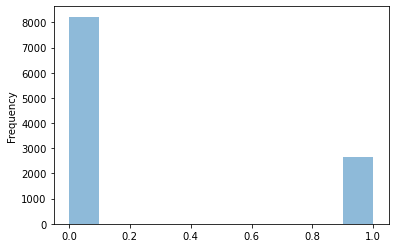

In [14]:
# See difference in number of hits vs non-hits in completed dataset
ax = songs_charts['Hit'].plot.hist(alpha=0.5)

In [15]:
print("Number of hit songs:",len(songs_charts[songs_charts['Hit']==1]))
print("Proportion of hit songs:",len(songs_charts[songs_charts['Hit']==1])/len(songs_charts))

Number of hit songs: 2637
Proportion of hit songs: 0.2427059364933272


In [16]:
# Function to create 'star' column, indicating whether artist charted 
# on billboard hot 100 charts before
def find_star(x,y,data):
    df = data[data.track_artist==x] # get df for song's artist
    df = df.sort_values(['song_year','track_album_name','trending_year']).reset_index()
    ind = df[df.track_name==y].index[0] # get index of row for song
    
    # If this is first song for artist, they are not a star
    if ind==0: 
        return 0
        
    # If this isn't artist's first song
    elif (df.iloc[ind-1].Hit==1): # if previous song of artist is hit
        return 1
    elif ind-2>=0: # if any of the previous songs were hits
        if 1 in df.iloc[0:ind].Hit:
            return 1
        else:
            return 0
    else: # if none of the previous songs were hits
        return 0

In [17]:
# Determine if artist is star based on whether song charted 
# billboard charts previously
songs_charts['star'] = songs_charts.apply(lambda x: find_star(x['track_artist'],
                                                  x['track_name'],
                                                  songs_charts),axis=1)

In [18]:
# Drop extraneous columns
songs_charts.drop(columns=['Date','track_id','track_album_id','track_album_release_date',
                           'playlist_id','playlist_name','Song','Performer','track_popularity',
                           'new_performer','new_song','new_track_name','new_track_artist','language']
                            ,inplace=True)
songs_charts.dtypes

track_name            object
track_artist          object
lyrics                object
track_album_name      object
playlist_genre        object
playlist_subgenre     object
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
duration_ms            int64
song_year              int64
trending_year          int64
Weeks_On_Chart         int64
Hit                    int64
star                   int64
dtype: object

In [19]:
# Rename columns
songs_charts.rename(columns={'track_name': 'song_name',
                             'track_artist':'artist_name',
                             'track_album_name':'album_name',
                             'playlist_genre':'genre',
                             'playlist_subgenre':'subgenre',
                             'Weeks_On_Chart':'weeks_on_chart',
                             'Hit':'hit'}, inplace=True)
songs_charts.dtypes

song_name            object
artist_name          object
lyrics               object
album_name           object
genre                object
subgenre             object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
song_year             int64
trending_year         int64
weeks_on_chart        int64
hit                   int64
star                  int64
dtype: object

In [20]:
songs_charts.head(10)

,song_name,artist_name,lyrics,album_name,genre,subgenre,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,duration_ms,song_year,trending_year,weeks_on_chart,hit,star
6354,?,MF DOOM,NA My servants began to forge what was to beco...,Operation: Doomsday (Complete),rap,gangster rap,0.532,0.629,10,-7.955,...,0.000000,0.4780,0.545,94.030,188893,2011,0,0,0,0
2876,0 To 100 / The Catch Up,Drake,NA NA Fuck bein' on some chill shit We go 0 to...,0 To 100 / The Catch Up,r&b,urban contemporary,0.559,0.716,11,-3.964,...,0.000000,0.2520,0.504,176.618,275227,2013,2014,20,1,1
5288,10%,KAYTRANADA,You keep on takin' from me But where's my ten ...,BUBBA,r&b,urban contemporary,0.794,0.757,6,-6.644,...,0.000306,0.0621,0.615,107.990,186680,2019,0,0,0,1
3325,1000 Nights,FRENSHIP,When the fever's gone And the road's to dust I...,1000 Nights,pop,indie poptimism,0.594,0.709,6,-9.541,...,0.056200,0.0738,0.587,90.001,240293,2017,0,0,0,1
7988,1000 Rounds,Pouya,"Bullets fly, legs buckle, bodies pile to the s...",1000 Rounds,rap,gangster rap,0.825,0.761,8,-5.389,...,0.003590,0.3340,0.161,149.970,163371,2017,0,0,0,0
7135,"100 Bands (feat. Quavo, 21 Savage, YG & Meek M...",Mustard,"Whoop, woo!Y'all already know who I am? Right?...","100 Bands (feat. Quavo, 21 Savage, YG & Meek M...",r&b,urban contemporary,0.871,0.493,9,-6.775,...,0.000000,0.0917,0.157,93.016,179388,2019,0,0,0,1
6104,100 Miles and Running (ft. Wale & John Lindahl),Logic,"Woo, woo, yeah Alright, here we go Yeah yeah, ...",YSIV,rap,hip hop,0.835,0.929,7,-3.595,...,0.000001,0.3800,0.960,119.047,353453,2018,0,0,0,1
3678,100 Shooters (feat. Meek Mill),Future,"Tay Keith, fuck these niggas up Yeah, The Wizr...",100 Shooters (feat. Meek Mill),rap,hip hop,0.645,0.675,1,-5.282,...,0.000000,0.2730,0.171,120.672,209120,2019,0,0,0,1
10832,101,WALLA,Don't you know about this road of rust? People...,101,pop,indie poptimism,0.710,0.827,0,-5.244,...,0.000013,0.0896,0.833,110.003,203500,2015,0,0,0,0
5187,10 Bands,Joyner Lucas,"Uh, uh-huh Frikki-frikki Ten bands (Uh), twent...",10 Bands,rap,hip hop,0.893,0.839,11,-6.785,...,0.000018,0.1130,0.801,129.998,214155,2019,0,0,0,0


## Save processed datasets to data folder

In [21]:
# Save dataset to raw/interim
songs_charts.to_csv("~/w266_project_topmusichits/data/interim/songs_charts_new_all.csv",index=False)

In [22]:
# Create dataset for songs in the 2000s
songs_charts_2 = songs_charts[songs_charts.song_year>=2000]

# Ensure that song is also trending within the 2000s (with a 5-year grace period)
songs_charts_2 = songs_charts_2[(songs_charts_2.trending_year==0) | 
                 ((songs_charts_2.trending_year!=0) & 
                  (songs_charts_2.trending_year>=1995))]
print("Length of songs 2000 onward:", len(songs_charts_2))
print("Number of hit songs:",len(songs_charts_2[songs_charts_2['hit']==1]))
print("Proportion of hit songs:",len(songs_charts_2[songs_charts_2['hit']==1])/len(songs_charts_2))
songs_charts_2.head(10)

Length of songs 2000 onward: 8546
Number of hit songs: 1608
Proportion of hit songs: 0.1881582026679148


,song_name,artist_name,lyrics,album_name,genre,subgenre,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,duration_ms,song_year,trending_year,weeks_on_chart,hit,star
6354,?,MF DOOM,NA My servants began to forge what was to beco...,Operation: Doomsday (Complete),rap,gangster rap,0.532,0.629,10,-7.955,...,0.000000,0.4780,0.545,94.030,188893,2011,0,0,0,0
2876,0 To 100 / The Catch Up,Drake,NA NA Fuck bein' on some chill shit We go 0 to...,0 To 100 / The Catch Up,r&b,urban contemporary,0.559,0.716,11,-3.964,...,0.000000,0.2520,0.504,176.618,275227,2013,2014,20,1,1
5288,10%,KAYTRANADA,You keep on takin' from me But where's my ten ...,BUBBA,r&b,urban contemporary,0.794,0.757,6,-6.644,...,0.000306,0.0621,0.615,107.990,186680,2019,0,0,0,1
3325,1000 Nights,FRENSHIP,When the fever's gone And the road's to dust I...,1000 Nights,pop,indie poptimism,0.594,0.709,6,-9.541,...,0.056200,0.0738,0.587,90.001,240293,2017,0,0,0,1
7988,1000 Rounds,Pouya,"Bullets fly, legs buckle, bodies pile to the s...",1000 Rounds,rap,gangster rap,0.825,0.761,8,-5.389,...,0.003590,0.3340,0.161,149.970,163371,2017,0,0,0,0
7135,"100 Bands (feat. Quavo, 21 Savage, YG & Meek M...",Mustard,"Whoop, woo!Y'all already know who I am? Right?...","100 Bands (feat. Quavo, 21 Savage, YG & Meek M...",r&b,urban contemporary,0.871,0.493,9,-6.775,...,0.000000,0.0917,0.157,93.016,179388,2019,0,0,0,1
6104,100 Miles and Running (ft. Wale & John Lindahl),Logic,"Woo, woo, yeah Alright, here we go Yeah yeah, ...",YSIV,rap,hip hop,0.835,0.929,7,-3.595,...,0.000001,0.3800,0.960,119.047,353453,2018,0,0,0,1
3678,100 Shooters (feat. Meek Mill),Future,"Tay Keith, fuck these niggas up Yeah, The Wizr...",100 Shooters (feat. Meek Mill),rap,hip hop,0.645,0.675,1,-5.282,...,0.000000,0.2730,0.171,120.672,209120,2019,0,0,0,1
10832,101,WALLA,Don't you know about this road of rust? People...,101,pop,indie poptimism,0.710,0.827,0,-5.244,...,0.000013,0.0896,0.833,110.003,203500,2015,0,0,0,0
5187,10 Bands,Joyner Lucas,"Uh, uh-huh Frikki-frikki Ten bands (Uh), twent...",10 Bands,rap,hip hop,0.893,0.839,11,-6.785,...,0.000018,0.1130,0.801,129.998,214155,2019,0,0,0,0


In [23]:
# Save 2000s dataset to raw/interim
songs_charts_2.to_csv("~/w266_project_topmusichits/data/interim/songs_charts_new_2000s.csv",index=False)

## Create final dataset for modeling

In [25]:
songs = pd.read_csv('~/w266_project_topmusichits/data/interim/songs_charts_new_2000s_meta.csv')
songs.head()

,song_name,artist_name,lyrics,album_name,genre,subgenre,danceability,energy,key,loudness,...,num_nonlexvoc_1,num_nonlexvoc_1_r_label,danceability2,energy2,loudness2,speechiness2,acousticness2,liveness2,valence2,tempo2
0,Tho Dem Wraps,Nelly,"I boss thru in a Hummer, Murphy the Don, Lizzi...",Country Grammar,rap,southern hip hop,0.656,0.795,2,-6.859,...,26,low,medium,high,medium,medium,low,high,medium,high
1,Beautiful Day,U2,"The heart is a bloom, shoots up through the st...",All That You Can't Leave Behind,rock,permanent wave,0.536,0.928,11,-6.492,...,23,low,low,high,medium,medium,low,medium,medium,high
2,Kryptonite,3 Doors Down,"Well, I took a walk around the world to ease m...",The Better Life,rock,permanent wave,0.545,0.865,11,-5.708,...,9,low,low,high,medium,low,low,medium,medium,low
3,Without You,Lucy Pearl,Girl you know I want you And I dont know what ...,Lucy Pearl,r&b,new jack swing,0.740,0.648,7,-4.510,...,33,low,high,medium,high,high,high,high,high,low
4,Ride Wit Me,Nelly,Where they at? Where they at? Where they at? W...,Country Grammar,rap,hip hop,0.854,0.692,7,-6.625,...,94,high,high,medium,medium,medium,medium,high,high,low


In [26]:
# Create new column that indicates whether song is on Billboard charts or not (1 or 0)
songs['star2'] = np.where(songs['star']==0,"no","yes")


In [27]:
songs.columns

Index(['song_name', 'artist_name', 'lyrics', 'album_name', 'genre', 'subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'song_year', 'trending_year', 'weeks_on_chart', 'hit',
       'star', 'num_nonlexvoc_1', 'num_nonlexvoc_1_r_label', 'danceability2',
       'energy2', 'loudness2', 'speechiness2', 'acousticness2', 'liveness2',
       'valence2', 'tempo2', 'star2'],
      dtype='object')

In [28]:
songs.drop(columns=['subgenre','danceability','energy','key','loudness',
                    'mode','speechiness','acousticness','instrumentalness',
                    'liveness','valence','tempo','duration_ms','trending_year',
                    'weeks_on_chart','star','energy2','liveness2','num_nonlexvoc_1'],inplace=True)
songs.columns

Index(['song_name', 'artist_name', 'lyrics', 'album_name', 'genre',
       'song_year', 'hit', 'num_nonlexvoc_1_r_label', 'danceability2',
       'loudness2', 'speechiness2', 'acousticness2', 'valence2', 'tempo2',
       'star2'],
      dtype='object')

In [29]:
songs.rename(columns={'danceability2':'danceability',
                        'loudness2':'loudness',
                        'speechiness2':'speechiness',
                        'acousticness2':'acousticness',
                        'valence2':'valence',
                        'tempo2':'tempo',
                        'star2':'star',
                        'num_nonlexvoc_1_r_label':'num_nonlexvoc'},inplace=True)
songs.columns

Index(['song_name', 'artist_name', 'lyrics', 'album_name', 'genre',
       'song_year', 'hit', 'num_nonlexvoc', 'danceability', 'loudness',
       'speechiness', 'acousticness', 'valence', 'tempo', 'star'],
      dtype='object')

In [30]:
songs.head()

,song_name,artist_name,lyrics,album_name,genre,song_year,hit,num_nonlexvoc,danceability,loudness,speechiness,acousticness,valence,tempo,star
0,Tho Dem Wraps,Nelly,"I boss thru in a Hummer, Murphy the Don, Lizzi...",Country Grammar,rap,2000,0,low,medium,medium,medium,low,medium,high,no
1,Beautiful Day,U2,"The heart is a bloom, shoots up through the st...",All That You Can't Leave Behind,rock,2000,1,low,low,medium,medium,low,medium,high,yes
2,Kryptonite,3 Doors Down,"Well, I took a walk around the world to ease m...",The Better Life,rock,2000,1,low,low,medium,low,low,medium,low,no
3,Without You,Lucy Pearl,Girl you know I want you And I dont know what ...,Lucy Pearl,r&b,2000,0,low,high,high,high,high,high,low,yes
4,Ride Wit Me,Nelly,Where they at? Where they at? Where they at? W...,Country Grammar,rap,2000,1,high,high,medium,medium,medium,high,low,yes


In [31]:
songs = songs[['song_year','song_name','artist_name','album_name','genre',
               'lyrics','danceability','loudness','speechiness','acousticness',
               'valence','tempo','num_nonlexvoc','star','hit']]
songs.head()

,song_year,song_name,artist_name,album_name,genre,lyrics,danceability,loudness,speechiness,acousticness,valence,tempo,num_nonlexvoc,star,hit
0,2000,Tho Dem Wraps,Nelly,Country Grammar,rap,"I boss thru in a Hummer, Murphy the Don, Lizzi...",medium,medium,medium,low,medium,high,low,no,0
1,2000,Beautiful Day,U2,All That You Can't Leave Behind,rock,"The heart is a bloom, shoots up through the st...",low,medium,medium,low,medium,high,low,yes,1
2,2000,Kryptonite,3 Doors Down,The Better Life,rock,"Well, I took a walk around the world to ease m...",low,medium,low,low,medium,low,low,no,1
3,2000,Without You,Lucy Pearl,Lucy Pearl,r&b,Girl you know I want you And I dont know what ...,high,high,high,high,high,low,low,yes,0
4,2000,Ride Wit Me,Nelly,Country Grammar,rap,Where they at? Where they at? Where they at? W...,high,medium,medium,medium,high,low,high,yes,1


In [32]:
# Save final dataset to processed folder
songs.to_csv("~/w266_project_topmusichits/data/processed/songs_charts_final.csv",index=False)


8546


## Misc Analysis

In [23]:
sgs = pd.read_csv('~/w266_project_topmusichits/data/processed/songs_charts_new_2000s.csv',index_col=False)
sgs.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/sumedhshah94/w266_project_topmusichits/data/processed/songs_charts_new_2000s.csv'

In [ ]:
songs_1 = pd.read_csv('~/w266_project_topmusichits/data/interim/songs_charts.csv')
songs_2 = pd.read_csv('~/w266_project_topmusichits/data/interim/songs_charts_new_all.csv')

In [ ]:
songs_1.rename(columns={'track_name':'song_name',
                        'track_artist':'artist_name',
                        'track_album_name':'album_name',
                        'Hit':'hit'},inplace=True)
songs_1 = songs_1[['song_name','artist_name','album_name','hit']]
songs_2 = songs_2[['song_name','artist_name','album_name','hit']]

comb = pd.concat([songs_1,songs_2]).drop_duplicates(keep=False)
vals = songs_2[['song_name','artist_name','album_name','hit']]
vals[vals.artist_name.str.contains('Lady Gaga')]
#comb[comb.song_name.isnull()]

In [ ]:
# Verify no duplicate records
duplicate = songs_charts[songs_charts.duplicated(['song_name','artist_name'])].sort_values('song_name')
duplicate.head(10)

In [ ]:
# Check specific songs that have duplicate records, if any
new_charts[new_charts.Song=='22']

In [ ]:
songs = pd.read_csv("/home/sumedhshah94/w266_project_topmusichits/data/interim/songs_charts.csv",',')
songs.head(20)

In [ ]:
songs_2 = songs

In [ ]:
songs_2.dtypes

In [ ]:
# All hits
my_crosstab = pd.crosstab(index=songs_2["playlist_genre"], 
                            columns=songs["Hit"],
                             margins=True)
my_crosstab

In [ ]:
# Check hits by song year
my_crosstab_2 = pd.crosstab(index=songs_2["song_year"], 
                            columns=songs_2["Hit"],
                             margins=True)
my_crosstab_2

In [ ]:
songs = pd.read_csv("/home/sumedhshah94/w266_project_topmusichits/data/interim/songs_charts.csv")

In [ ]:
songs[songs.track_artist.str.contains('miguel')][['track_artist','track_name','song_year','Hit']].sort_values(['track_artist','song_year']).tail(50)

In [ ]:
artist = songs[songs.track_artist=='taylor swift']
artist.sort_values('song_year')

In [ ]:
songs_original = pd.read_csv("/home/sumedhshah94/w266_project_topmusichits/data/raw/spotify_songs.csv",',')

In [ ]:
songs_original[songs_original.track_name=='Dangerous Woman']['playlist_genre']

In [ ]:
charts = pd.read_csv("/home/sumedhshah94/w266_project_topmusichits/data/raw/billboard_hot_100_charts.csv",',')
charts.head()

In [ ]:
charts[charts.Performer=='Ariana Grande'][charts.SongID.str.contains('The Way')]

In [ ]:
charts[charts.Performer.str.contains('Eminem')][charts.Song.str.contains('Forward')]

In [ ]:
artist = songs[songs.track_name.str.contains('feat')]
artist.sort_values('song_year')

In [ ]:
beyonce = songs[songs.track_artist.str.contains('beyonc')]
word = beyonce['track_artist'].iloc[0]

In [ ]:
unaccented = unidecode.unidecode(word)
unaccented